In [30]:
import pandas as pd
from pymongo import MongoClient
import numpy as np

In [ ]:
def clean_suffix_number(x):
    """
    Converts '1,3M' -> 1300000, '500K' -> 500000
    Handles Vietnamese comma decimals (1,3 -> 1.3)
    """
    if pd.isna(x) or x == "N/A": return np.nan
    
    # Standardize string
    x = str(x).upper().replace(',', '.') 
    
    multiplier = 1
    if 'M' in x:
        multiplier = 1_000_000
        x = x.replace('M', '')
    elif 'K' in x:
        multiplier = 1_000
        x = x.replace('K', '')
        
    try:
        return float(x) * multiplier
    except ValueError:
        return np.nan

def clean_currency_vnd(x):
    """
    Converts '12.801.218 VND' -> 12801218
    Removes dots (thousands separators) and 'VND'
    """
    if pd.isna(x) or x == "N/A": return np.nan
    
    # Remove ' VND' and remove '.' which is used as thousands separator in VN
    clean_str = str(x).replace(' VND', '').replace('.', '')
    
    try:
        return float(clean_str)
    except ValueError:
        return np.nan

def clean_percentage(x):
    """
    Converts '6,60%' -> 6.60
    """
    if pd.isna(x) or x == "N/A": return np.nan
    
    # Replace comma with dot, remove %
    clean_str = str(x).replace(',', '.').replace('%', '')
    
    try:
        return float(clean_str)
    except ValueError:
        return np.nan

In [32]:
client = MongoClient("mongodb://localhost:27017/")
db = client['tiktok_ads_db']
collection = db['creators_vn1']

In [33]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))


In [34]:
# Assuming 'df' is your DataFrame loaded from MongoDB

# 1. Clean "Followers" and "Median Views" (Handle K/M suffixes)
df['Followers'] = df['Followers'].apply(clean_suffix_number)
df['Median_Views'] = df['Median Views'].apply(clean_suffix_number)

# 2. Clean "Start Price" (Handle VND and dots)
df['Price'] = df['Start Price'].apply(clean_currency_vnd)

# 3. Clean "Engagement" (Handle % and comma)
df['Engagement'] = df['Engagement'].apply(clean_percentage)

# 4. Clean Scores (Just need to float them)
df['Collab_Score'] = pd.to_numeric(df['Collab Score'], errors='coerce')

# Check the result
print(df[['Name', 'Followers', 'Price', 'Engagement', 'Collab_Score']].head())

                Name   Followers       Price  Engagement  Collab_Score
0            CÁO NHỎ   4500000.0         NaN       14.06          79.2
1       Mai Trí Thức   1700000.0         NaN        9.15          82.2
2        Vitamin Mèo   2600000.0         NaN       12.47          77.2
3  Nguyễn Hoàng Vinh  12000000.0  12801218.0        6.60          77.4
4        Tuyền Xu TV   3900000.0  10000000.0        8.91          92.5


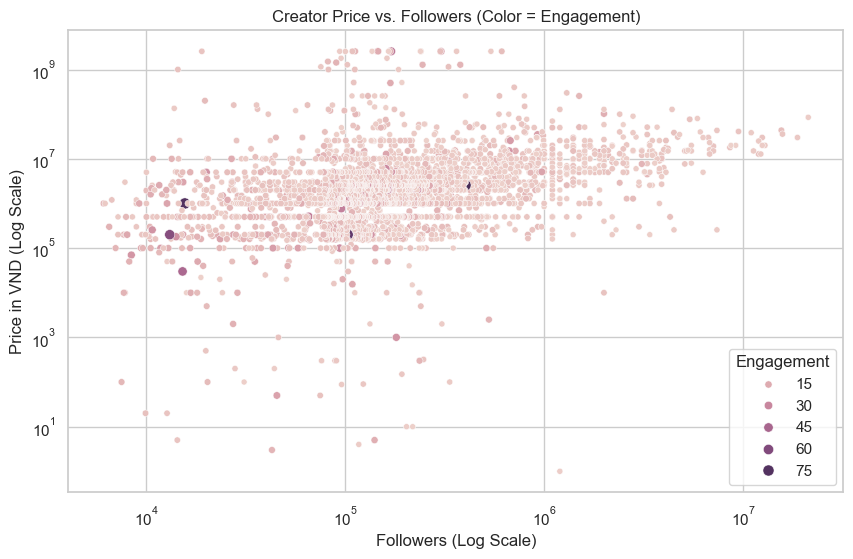

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Followers', y='Price', hue='Engagement', size='Engagement')

# Log scale is usually better for Followers/Price as they vary wildly
plt.xscale('log') 
plt.yscale('log')

plt.title('Creator Price vs. Followers (Color = Engagement)')
plt.xlabel('Followers (Log Scale)')
plt.ylabel('Price in VND (Log Scale)')
plt.show()

In [36]:
numeric_cols = ['Collab Score', 'Broadcast Score', 'Followers', 'Median Views', 'Engagement', 'Start Price']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [37]:
df.head(20)

,_id,Broadcast Score,Collab Score,Country,Engagement,Followers,ID,Median Views,Name,Start Price,Tags,avatar_local_path,avatar_url,Median_Views,Price,Collab_Score
0,caonho,98.6,79.2,Việt Nam,14.06,4500000.0,caonho,NaN,CÁO NHỎ,NaN,"Thương mại điện tử (không dùng ứng dụng), Hài ...",D:\Khanh\hoc\ma nguon mo\New folder\caonho.jpg,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,372600.0,NaN,79.2
1,maitrithuc2020,95.8,82.2,Việt Nam,9.15,1700000.0,maitrithuc2020,NaN,Mai Trí Thức,NaN,"Âm nhạc, Nhảy, Hát nhép",D:\Khanh\hoc\ma nguon mo\New folder\maitrithuc...,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,691900.0,NaN,82.2
2,dntminh,92.3,77.2,Việt Nam,12.47,2600000.0,dntminh,NaN,Vitamin Mèo,NaN,"Thiết bị, Thú cưng, Sức khỏe, Chăm sóc thú cưng",D:\Khanh\hoc\ma nguon mo\New folder\dntminh.jpg,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,588800.0,NaN,77.2
3,hoangvinhhh,91.6,77.4,Việt Nam,6.60,12000000.0,hoangvinhhh,NaN,Nguyễn Hoàng Vinh,NaN,"Cuộc sống hàng ngày, Trò chơi điện tử, Tin tức...",D:\Khanh\hoc\ma nguon mo\New folder\hoangvinhh...,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,1300000.0,12801218.0,77.4
4,tuyenxutv,90.2,92.5,Việt Nam,8.91,3900000.0,tuyenxutv,NaN,Tuyền Xu TV,NaN,"Game, Ứng dụng, Thiết kế & chăm sóc tóc, Trò c...",D:\Khanh\hoc\ma nguon mo\New folder\tuyenxutv.jpg,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,20000.0,10000000.0,92.5
5,duyen_158200,96.5,78.6,Việt Nam,8.90,2800000.0,duyen_158200,NaN,Rùa👅,NaN,"Thương mại điện tử (không dùng ứng dụng), Làm ...",D:\Khanh\hoc\ma nguon mo\New folder\duyen_1582...,https://p19-common-sign-useastred.tiktokcdn-eu...,620400.0,1280121.0,78.6
6,reencyngo,93.0,78.0,Việt Nam,4.97,12500000.0,reencyngo,NaN,Reency Ngô,NaN,"Sản phẩm chăm sóc cá nhân và làm đẹp khác, Tiể...",D:\Khanh\hoc\ma nguon mo\New folder\reencyngo.jpg,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,118100.0,30000000.0,78.0
7,tuankiet.2000,93.0,89.0,Việt Nam,7.29,9900000.0,tuankiet.2000,NaN,Kiệt Hà Tịnh,NaN,"Tin tức và Giải trí, Làm đẹp và chăm sóc cá nh...",D:\Khanh\hoc\ma nguon mo\New folder\tuankiet.2...,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,1900000.0,NaN,89.0
8,n.huyen2k4,93.8,79.8,Việt Nam,11.72,2100000.0,n.huyen2k4,NaN,Huyềnn Bạchh Đâyyy🐰,NaN,"May mặc & Phụ kiện, Làm đẹp và chăm sóc cá nhâ...",D:\Khanh\hoc\ma nguon mo\New folder\n.huyen2k4...,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,157700.0,NaN,79.8
9,__lyhan__,95.1,77.0,Việt Nam,11.62,2300000.0,__lyhan__,NaN,LYHAN,NaN,"Âm nhạc, Tin tức và Giải trí",D:\Khanh\hoc\ma nguon mo\New folder\__lyhan__.jpg,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,291600.0,NaN,77.0


/var/folders/bx/76lc9d494672gyzhxsmtn2jc0000gn/T/ipykernel_21626/328870983.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')


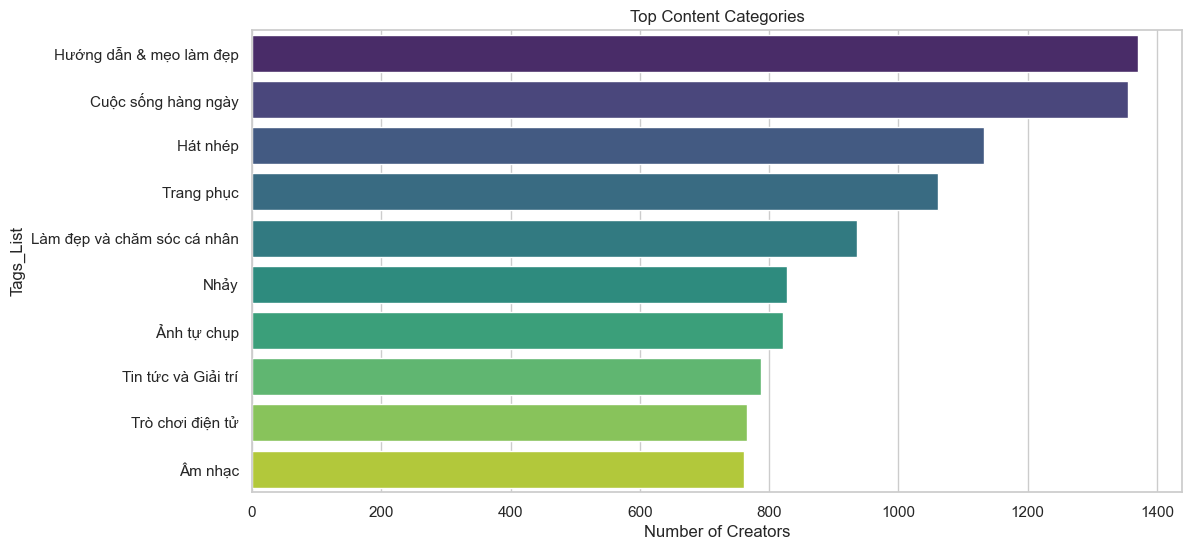

In [38]:
# 1. Split the string into a real list
df['Tags_List'] = df['Tags'].str.split(', ')

# 2. Explode the list so each tag gets its own row
df_tags = df.explode('Tags_List')

# 3. Count top tags
top_tags = df_tags['Tags_List'].value_counts().head(10)

# 4. Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
plt.title('Top Content Categories')
plt.xlabel('Number of Creators')
plt.show()

In [39]:
import numpy as np
df.replace("N/A", np.nan, inplace=True)

Missing Value Statistics:
                   Missing Count  Missing Percentage
Start Price                 9443          100.000000
Median Views                7916           83.829292
Broadcast Score             6766           71.650958
Price                       5864           62.098909
Collab Score                 226            2.393307
Collab_Score                 226            2.393307
Tags                         101            1.069575
Median_Views                  87            0.921317
Engagement                    83            0.878958
Name                           9            0.095309
avatar_local_path              8            0.084719
Followers                      2            0.021180
avatar_url                     2            0.021180
_id                            0            0.000000
ID                             0            0.000000
Country                        0            0.000000
Tags_List                      0            0.000000


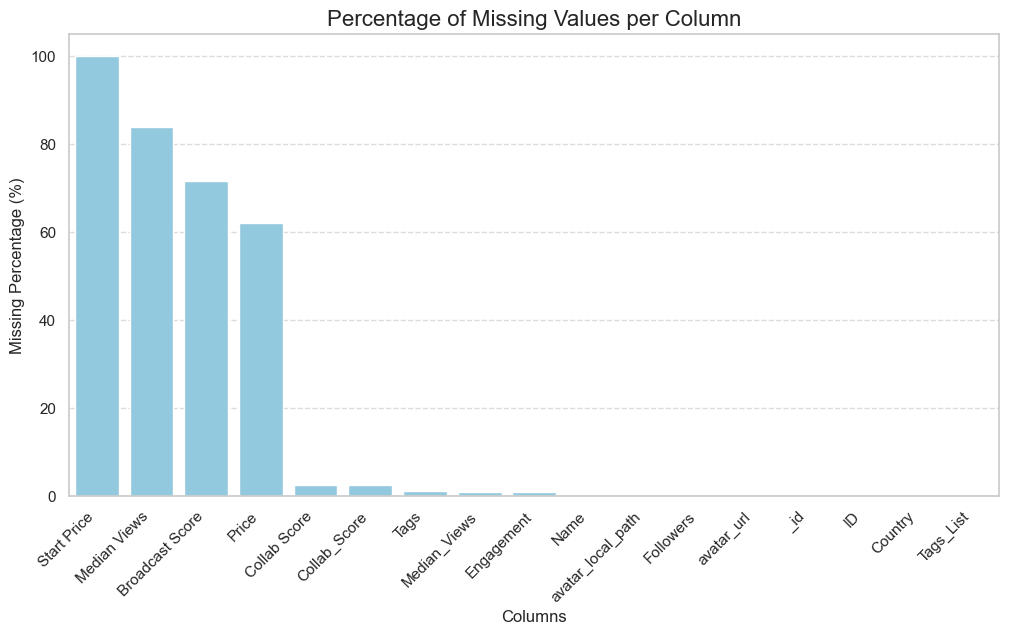

In [40]:
# 1. Load your data (Assuming df is your DataFrame from MongoDB)
# df = pd.DataFrame(list(collection.find({}))) 

# 2. Define what "Missing" looks like in your specific data
# You mentioned "N/A" is used, and often empty strings "" exist too.
missing_indicators = ["N/A", "n/a", "", "None", "null"]

# 3. Replace these text indicators with actual numpy NaN
df_cleaned = df.replace(missing_indicators, np.nan)

# 4. Calculate Missing Statistics
missing_count = df_cleaned.isnull().sum()
missing_percentage = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

# Create a summary table
missing_stats = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage', ascending=False)

print("Missing Value Statistics:")
print(missing_stats)

# 5. Visualize Missing Data
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_stats.index, y=missing_stats['Missing Percentage'], color='skyblue')

plt.title('Percentage of Missing Values per Column', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Missing Percentage (%)')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [41]:
#Drop >70% missing value in the dataframe 
drop_columns = ["Start Price", "Median Views", "Broadcast Score", "Collab Score"]
df.drop(columns=drop_columns, inplace=True)
df.head()

,_id,Country,Engagement,Followers,ID,Name,Tags,avatar_local_path,avatar_url,Median_Views,Price,Collab_Score,Tags_List
0,caonho,Việt Nam,14.06,4500000.0,caonho,CÁO NHỎ,"Thương mại điện tử (không dùng ứng dụng), Hài ...",D:\Khanh\hoc\ma nguon mo\New folder\caonho.jpg,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,372600.0,NaN,79.2,"[Thương mại điện tử (không dùng ứng dụng), Hài..."
1,maitrithuc2020,Việt Nam,9.15,1700000.0,maitrithuc2020,Mai Trí Thức,"Âm nhạc, Nhảy, Hát nhép",D:\Khanh\hoc\ma nguon mo\New folder\maitrithuc...,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,691900.0,NaN,82.2,"[Âm nhạc, Nhảy, Hát nhép]"
2,dntminh,Việt Nam,12.47,2600000.0,dntminh,Vitamin Mèo,"Thiết bị, Thú cưng, Sức khỏe, Chăm sóc thú cưng",D:\Khanh\hoc\ma nguon mo\New folder\dntminh.jpg,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,588800.0,NaN,77.2,"[Thiết bị, Thú cưng, Sức khỏe, Chăm sóc thú cưng]"
3,hoangvinhhh,Việt Nam,6.60,12000000.0,hoangvinhhh,Nguyễn Hoàng Vinh,"Cuộc sống hàng ngày, Trò chơi điện tử, Tin tức...",D:\Khanh\hoc\ma nguon mo\New folder\hoangvinhh...,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,1300000.0,12801218.0,77.4,"[Cuộc sống hàng ngày, Trò chơi điện tử, Tin tứ..."
4,tuyenxutv,Việt Nam,8.91,3900000.0,tuyenxutv,Tuyền Xu TV,"Game, Ứng dụng, Thiết kế & chăm sóc tóc, Trò c...",D:\Khanh\hoc\ma nguon mo\New folder\tuyenxutv.jpg,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,20000.0,10000000.0,92.5,"[Game, Ứng dụng, Thiết kế & chăm sóc tóc, Trò ..."


Missing Value Statistics:
                   Missing Count  Missing Percentage
Price                       5864           62.098909
Collab_Score                 226            2.393307
Tags                         101            1.069575
Median_Views                  87            0.921317
Engagement                    83            0.878958
Name                           9            0.095309
avatar_local_path              8            0.084719
Followers                      2            0.021180
avatar_url                     2            0.021180
_id                            0            0.000000
Country                        0            0.000000
ID                             0            0.000000
Tags_List                      0            0.000000


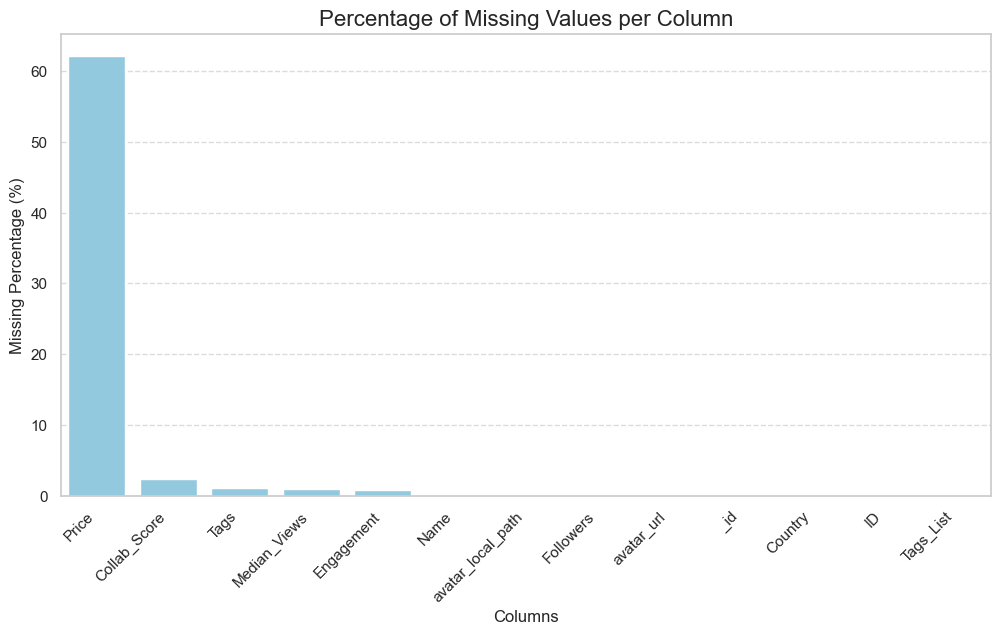

In [42]:
# 1. Define what "Missing" looks like in your specific data
# You mentioned "N/A" is used, and often empty strings "" exist too.
missing_indicators = ["N/A", "n/a", "", "None", "null"]

# 2. Replace these text indicators with actual numpy NaN
df_cleaned = df.replace(missing_indicators, np.nan)

# 3. Calculate Missing Statistics
missing_count = df_cleaned.isnull().sum()
missing_percentage = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

# Create a summary table
missing_stats = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage', ascending=False)

print("Missing Value Statistics:")
print(missing_stats)

# 4. Visualize Missing Data
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_stats.index, y=missing_stats['Missing Percentage'], color='skyblue')

plt.title('Percentage of Missing Values per Column', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Missing Percentage (%)')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

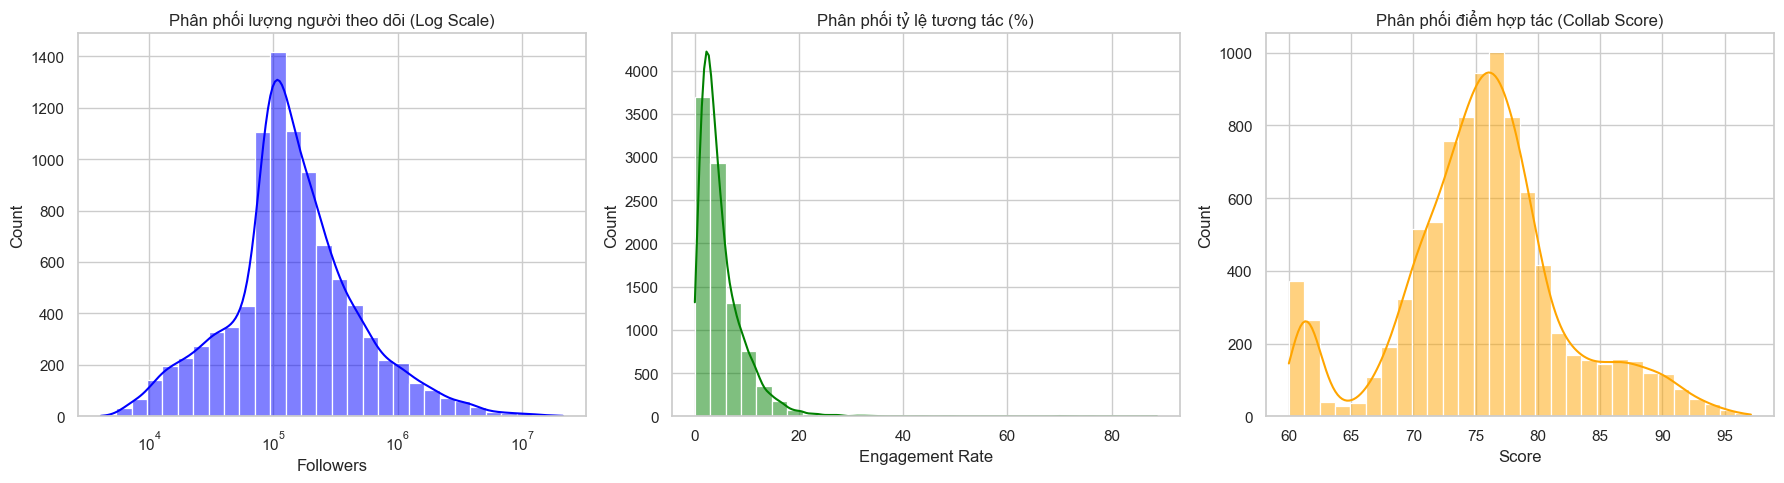

In [43]:
sns.set(style="whitegrid")

# Tạo khung 3 biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Phân phối Followers (Dùng log scale vì chênh lệch rất lớn)
sns.histplot(df['Followers'].dropna(), bins=30, kde=True, log_scale=True, ax=axes[0], color='blue')
axes[0].set_title('Phân phối lượng người theo dõi (Log Scale)')
axes[0].set_xlabel('Followers')

# 2. Phân phối Engagement
sns.histplot(df['Engagement'].dropna(), bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Phân phối tỷ lệ tương tác (%)')
axes[1].set_xlabel('Engagement Rate')

# 3. Phân phối Collab Score
sns.histplot(df['Collab_Score'].dropna(), bins=30, kde=True, ax=axes[2], color='orange')
axes[2].set_title('Phân phối điểm hợp tác (Collab Score)')
axes[2].set_xlabel('Score')

plt.tight_layout()
plt.show()

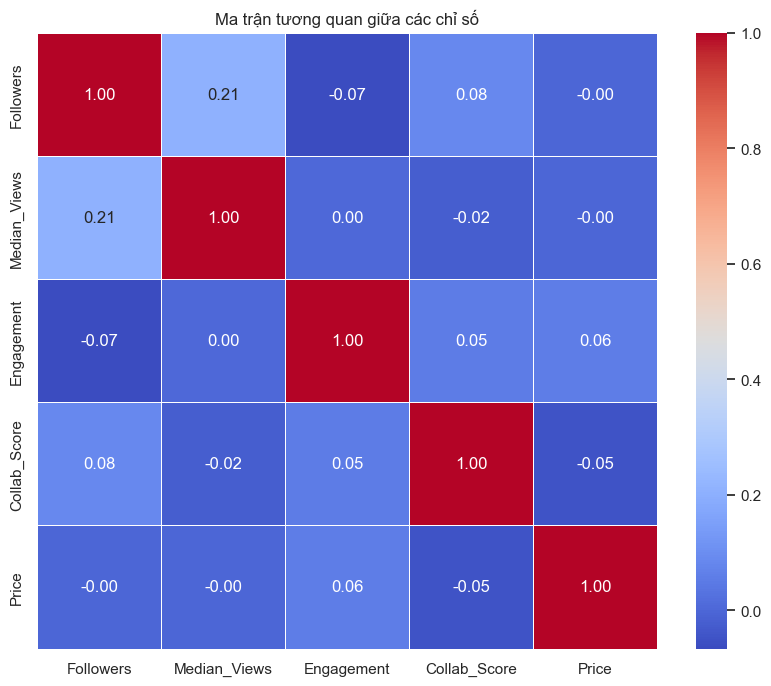

In [44]:
# Chọn các biến số quan trọng
cols_to_corr = ['Followers', 'Median_Views', 'Engagement', 'Collab_Score', 'Price']

# Tính ma trận tương quan
corr_matrix = df[cols_to_corr].corr()

# Vẽ Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Ma trận tương quan giữa các chỉ số')
plt.show()

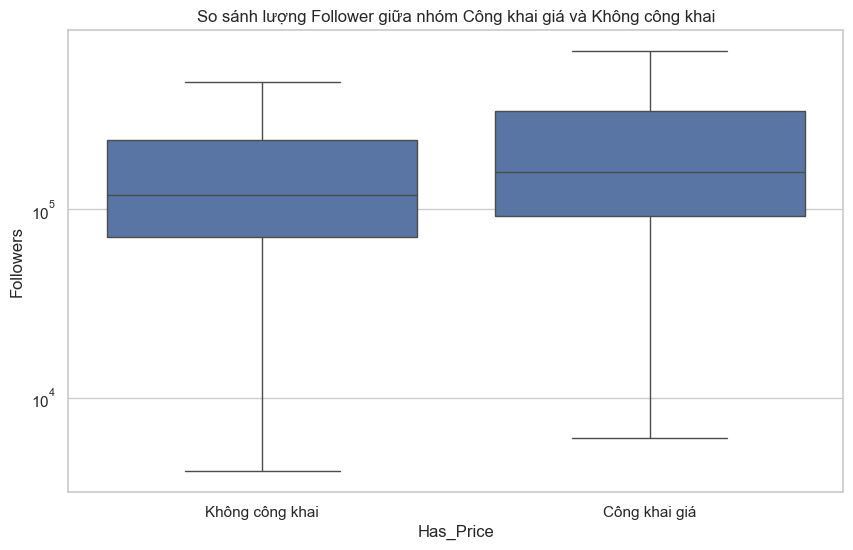

In [45]:
# Tạo cột phân loại: Có giá vs Không có giá
df['Has_Price'] = df['Price'].notnull().map({True: 'Công khai giá', False: 'Không công khai'})

# So sánh lượng Follower giữa 2 nhóm
plt.figure(figsize=(10, 6))
sns.boxplot(x='Has_Price', y='Followers', data=df, showfliers=False) # showfliers=False để ẩn các điểm ngoại lai quá xa
plt.yscale('log') # Dùng log scale để dễ nhìn
plt.title('So sánh lượng Follower giữa nhóm Công khai giá và Không công khai')
plt.show()

/var/folders/bx/76lc9d494672gyzhxsmtn2jc0000gn/T/ipykernel_21626/4255543099.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


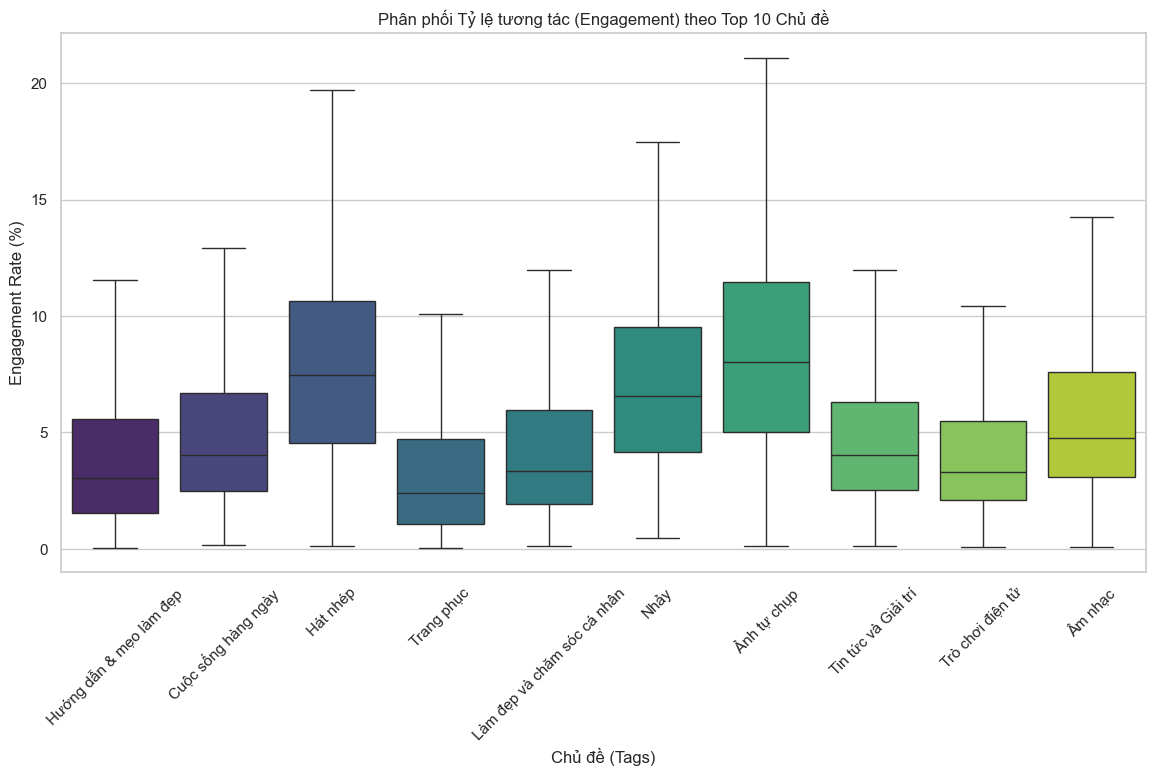

In [46]:
# 1. Explode dữ liệu ra từng dòng
df_exploded = df.explode('Tags_List')

# 2. Lấy danh sách Top 10 Tags
top_tags = df_exploded['Tags_List'].value_counts().head(10).index

# 3. Lọc dữ liệu chỉ lấy Top 10 Tags
df_top_tags = df_exploded[df_exploded['Tags_List'].isin(top_tags)]

# --- BƯỚC SỬA QUAN TRỌNG NHẤT ---
# 4. Reset index để tránh lỗi "duplicate labels"
df_top_tags = df_top_tags.reset_index(drop=True)

# 5. Vẽ biểu đồ
plt.figure(figsize=(14, 7))
sns.boxplot(
    x='Tags_List', 
    y='Engagement',  # LƯU Ý: Phải dùng cột đã làm sạch (dạng số)
    data=df_top_tags, 
    palette='viridis', 
    showfliers=False,
    order=top_tags 
)

plt.xticks(rotation=45)
plt.title('Phân phối Tỷ lệ tương tác (Engagement) theo Top 10 Chủ đề')
plt.ylabel('Engagement Rate (%)')
plt.xlabel('Chủ đề (Tags)')
plt.show()